In [1]:
import rasterio as rio
import numpy as np
from netCDF4 import Dataset
# from oesgdal import gdal
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import pandas as pd
# rio.open()

In [2]:
dev_present_file = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\oregon\devices-present\trim_sets_flow_inset_allruns.nc"
dev_notpresent_file = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\oregon\devices-not-present\trim_sets_flow_inset_allruns.nc"
bc_file = r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\oregon\boundary-condition\BC_Annie_Annual_SETS.csv"
run_order_file=r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\oregon\run-order\run_order_wecs_bad_runs_removed_v2.csv"
plotvar = "TAUMAX"
receptor_filename=r"H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\oregon\receptor\grainsize_receptor.tif"
receptor=True


In [3]:

file = Dataset(dev_notpresent_file)
data_nodev = file.variables[plotvar][:]
file.close()
wec_diff_nodev = np.zeros(np.shape(data_nodev[0, 0, :, :]))

In [4]:
def critical_shear_stress(D_meters, rhow=1024, nu=1e-6, s=2.65, g=9.81):
    # D_meters = grain size in meters, can be array
    # rhow = density of water in kg/m3
    # nu = kinematic viscosity of water
    # s = specific gravity of sediment
    # g = acceleratin due to gravity
    Dstar = ((g * (s-1))/ nu**2)**(1/3) * D_meters
    SHcr = (0.3/(1+1.2*Dstar)) + 0.055*(1-np.exp(-0.02 * Dstar))
    taucrit = (2.65 - 1) * g * D_meters * SHcr #in Pascals
    return taucrit

In [5]:

# Read The device present NetCDF file and parse contents needed for plotting
file_dev_present = Dataset(dev_present_file)

# X-coordinate of cell center
xcor = file_dev_present.variables["XCOR"][:].data
# Y-coordinate of cell center
ycor = file_dev_present.variables["YCOR"][:].data

# if we are running a structured case update the plot varaiable to what we can query
if plotvar == "TAUMAX -Structured":
    plotvar = "TAUMAX"

# Deprecated
# delft_time = file.variables['time'][:]
# depth = file.variables['DPS0'][:] # Initial bottom depth at zeta points (positive down)
# sed_fracs = np.squeeze(file.variables['LYRFRAC'][0,0,:,0,:,:])
if plotvar != "VEL": #not velocity
    # set as 4D netcdf files
    data_wecs = file_dev_present.variables[plotvar][:]

else: #Larval Transport Velocity
    # 5D netcdf files. Pick last depth that corresponds to bottom
    u = file_dev_present.variables["U1"][:, :, -1, :, :]
    v = file_dev_present.variables["V1"][:, :, -1, :, :]
    data_wecs = np.sqrt(u**2 + v**2)

# close the device prsent file
file_dev_present.close()

if plotvar == "TAUMAX": # Grain Size
    # Empirical calculation of Sediment D50s and critical shear stress for erosion
    # nsed = np.shape(sed_fracs)[0]
    # sed_d50 = np.array([3.5e-4, 2.75e-4, 2.0e-4, 0.75e-4])
    # layer_d50 = np.zeros((np.shape(sed_fracs)[1], np.shape(sed_fracs)[2]))
    # for ised in range(0,nsed):
    #    layer_d50 = layer_d50 + np.squeeze(sed_fracs[ised,:,:])*sed_d50[ised]
    #
    # taucrit = 1.65*980*((layer_d50*10**6)/10000)*0.0419

    # E & E case
    # soil density * gravity * grain size(m) * 10^6 / unit converter *
    # taucrit = 1.65*980*((1.9e-4*10**6)/10000)*0.0419

    # Add in the receptor here. This started as grain size but is geeralized
    if receptor_filename is not None:
        # data = rio.open(receptor_filename)
        # img = data.read(1)
        # receptor_array = img.ReadAsArray()
        data = rio.open(receptor_filename)
        receptor_array = data.read(1)

        receptor_array = np.transpose(receptor_array)
        receptor_array[receptor_array < 0] = 0
        # soil density * gravity * grain size array * 10^6 / unit converter *
        # taucrit = 1.65*980*((gs_array*10**6)/10000)*0.0419

        # convert micron to cm 1 micron is 1e-4
        # soil density (g/cm^2) * standard gravity (cm/s^2) * (micron / (convert to cm)) * unit conversion
        # taucrit = 1.65 * 980 * ((receptor_array) / 10000) * 0.0419
        taucrit = critical_shear_stress(D_meters=receptor_array * 1e-6,
                            rhow=1024,
                            nu=1e-6,
                            s=2.65,
                            g=9.81) #units N/m2 = Pa
    else:
        # taucrit without a receptor
        # taucrit = 1.65 * 980 * 0.0419
        #Assume the following grain sizes and conditions for typical beach sand (Nielsen, 1992 p.108)
        taucrit = critical_shear_stress(D_meters=200*1e-6, rhow=1024, nu=1e-6, s=2.65, g=9.81) #units N/m2 = Pa

elif plotvar == "VEL": #Larval Transport
    # Define critical velocity for motility as 0.05 m/s
    velcrit = 0.05 * np.ones(np.shape(np.squeeze(u[0, 0, :, :])))


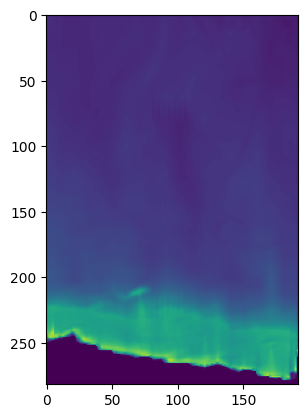

In [6]:
data_wecs.shape
fig,ax = plt.subplots()
ax.imshow(data_wecs[0,0,:])

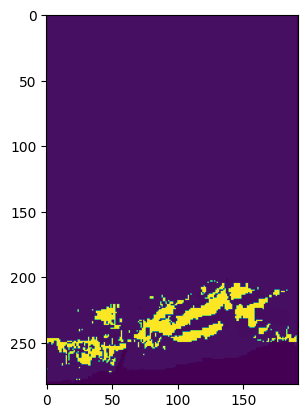

In [7]:

fig,ax = plt.subplots()
ax.imshow(taucrit)

In [8]:

# Load and parse run order file. This csv file has the wave conditions for each case. The wave conditions are listed in the order of cases as they are
# stored in the first dimension of data_wecs or data_nodev
df_run_order = pd.read_csv(run_order_file)

# filter out bad runs from wecs
df_run_order = df_run_order.loc[df_run_order["bad_run"] != "X", :]

# Load BC file with probabilities and find appropriate probability
BC_Annie = np.loadtxt(bc_file, delimiter=",", skiprows=1)

# ==============================
# Load WECs NetCDF file without wecs into variable data_nodev

# Find name of NetCDF device not present output file
# Read NetCDF file and parse contents needed for plotting
file = Dataset(dev_notpresent_file)
if plotvar != "VEL":
    data_nodev = file.variables[plotvar][:]
else:
    u = file.variables["U1"][:, :, -1, :, :]
    v = file.variables["V1"][:, :, -1, :, :]
    #data_bs
    data_nodev = np.sqrt(u**2 + v**2)

# close the device not present file
file.close()


In [9]:

# create zero arrays for the device present / not present
wec_diff_nodev = np.zeros(np.shape(data_nodev[0, 0, :, :]))
wec_diff_wecs = np.zeros(np.shape(data_wecs[0, 0, :, :]))

wec_diff_nodev2 = np.zeros(np.shape(data_nodev[0, 0, :, :]))
wec_diff_wecs2 = np.zeros(np.shape(data_wecs[0, 0, :, :]))
# wec_diff = np.zeros(np.shape(data_wecs[0,0,:,:]))

# flip the data arrays
data_nodev = np.flip(data_nodev, axis=3)
data_wecs = np.flip(data_wecs, axis=3)


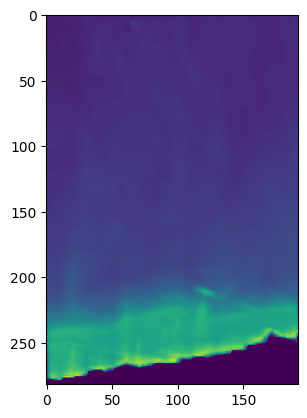

In [10]:
data_nodev.shape
fig,ax=plt.subplots()
ax.imshow(data_nodev[0,0,:])

In [11]:

# =======================================================
# set up a dataframe of probabilities
df = pd.DataFrame(
    {
        "Hs": BC_Annie[:, 0].astype(float),
        "Tp": BC_Annie[:, 1].astype(int).astype(str),
        "Dir": BC_Annie[:, 2].astype(int).astype(str),
        "prob": BC_Annie[:, 4].astype(float) / 100.0,
    },
)
# generate a primary key (string) for merge with the run order based on forcing
df["pk"] = (
    ["Hs"]
    + df["Hs"].map("{:.2f}".format)
    + ["Tp"]
    + df["Tp"].str.pad(2, fillchar="0")
    + ["Dir"]
    + df["Dir"]
)

# merge to the run order. This trims out runs that we want dropped.
# df_merge = pd.merge(df_run_order, df_ro_no_wecs, how = 'left', on = 'bc_name')
df_merge = pd.merge(df_run_order, df, how="left", left_on="bc_name", right_on="pk")
# Loop through all boundary conditions and create images
# breakpoint()


In [12]:
df_merge

,nowec_run_id,bc_name,wec_run_id,bad_run,Hs,Tp,Dir,prob,pk
0,1,Hs1.23Tp14Dir248,1,NaN,1.23,14,248,0.02729,Hs1.23Tp14Dir248
1,2,Hs1.37Tp15Dir224,2,NaN,1.37,15,224,0.00204,Hs1.37Tp15Dir224
2,3,Hs1.49Tp07Dir304,3,NaN,1.49,7,304,0.06664,Hs1.49Tp07Dir304
3,4,Hs1.54Tp08Dir278,4,NaN,1.54,8,278,0.11188,Hs1.54Tp08Dir278
4,5,Hs1.70Tp07Dir244,5,NaN,1.70,7,244,0.02212,Hs1.70Tp07Dir244
5,6,Hs1.76Tp06Dir221,6,NaN,1.76,6,221,0.00390,Hs1.76Tp06Dir221
6,7,Hs1.81Tp09Dir298,7,NaN,1.81,9,298,0.08297,Hs1.81Tp09Dir298
7,8,Hs1.85Tp13Dir277,8,NaN,1.85,13,277,0.08674,Hs1.85Tp13Dir277
8,10,Hs2.08Tp16Dir295,10,NaN,2.08,16,295,0.01540,Hs2.08Tp16Dir295
9,11,Hs2.11Tp11Dir223,11,NaN,2.11,11,223,0.00227,Hs2.11Tp11Dir223


In [13]:

for run_wec, run_nowec, prob in zip(
    df_merge["wec_run_id"],
    df_merge["nowec_run_id"],
    df_merge["prob"],
):
    bcnum = int(run_nowec - 1)

    # ===============================================================
    # Compute normalized difference between with WEC and without WEC
    # QA dataframes are here
    # if np.isnan(data_wecs[run_wec, -1, :, :].data[:]).all() == True | np.isnan(data_nodev[run_nowec, -1, :, :].data[:]).all() == True:
    #    continue
    # wec_diff = wec_diff + prob*(data_w_wecs[bcnum,1,:,:] - data_wo_wecs[bcnum,1,:,:])/data_wo_wecs[bcnum,1,:,:]

    if plotvar == "TAUMAX":

        # if the shapes are the same then process. Otherwise, process to an array and stop
        if data_nodev[bcnum, -1, :, :].shape == taucrit.shape:

            # get max along the 2nd axis (time)
            data_wecs_max = np.amax(data_wecs, axis=1, keepdims=True)

            # get last axis value
            # data_wecs_max = data_wecs[:,[-1],:,:]

            # make a backup just in case
            # wec_diff_bs_b = wec_diff_bs
            # wec_diff_wecs_b = wec_diff_wecs

            if receptor == True:

                wec_diff_nodev = wec_diff_nodev + prob * data_nodev[bcnum,-1,:,:] / taucrit
                wec_diff_wecs = wec_diff_wecs + prob * data_wecs_max[bcnum,-1,:,:] / taucrit
                wec_diff_nodev2 = wec_diff_nodev2 + prob * data_nodev[bcnum, -1, :, :]
                wec_diff_wecs2 = wec_diff_wecs2 + prob * data_wecs_max[bcnum, -1, :, :]
                
            else:
                wec_diff_nodev = (wec_diff_nodev + prob * data_nodev[bcnum, -1, :, :])
                wec_diff_wecs = (wec_diff_wecs + prob * data_wecs_max[bcnum, -1, :, :])
            # pd.DataFrame(wec_diff_nodev).to_csv(r"H:\Projects\C1308_SEAT\SEAT_outputs\tester.csv")
            # with open("H:\Projects\C1308_SEAT\SEAT_outputs\tester_size", 'w') as file:
            #     file.write(f'{np.shape(wec_diff_nodev)}')
            # # create dataframe of subtraction for QA
            # wec_diff_df = (
            #     wec_diff_bs + prob * data_nodev[bcnum, -1, :, :]
            # ) - (wec_diff_wecs + prob * data_wecs[bcnum -1, :, :])
            # wec_diff_df = wec_diff_bs + prob * data_nodev[bcnum, -1, :, :]
            # wec_diff_df = np.transpose(wec_diff_df)
            # # removed flip 05/27/2022
            # # wec_diff_df = np.flip(wec_diff_df, axis=0)
            # wec_diff_df = pd.DataFrame(wec_diff_df)

            # dump for QA. Should make this more flexible
            # wec_diff_df.to_csv(fr'C:\Users\ependleton52\Documents\Projects\Sandia\SEAT_plugin\Code_Model\Codebase\oregon_coast_models\dataframes\out_wec{int(run_wec)}_nowec{int(run_nowec)}.csv', index = False)
            # breakpoint()
        else:
            newarray = np.transpose(data_nodev[bcnum, -1, :, :].data)
            array2 = np.flip(newarray, axis=0)
            numpy_array = array2
            rows, cols = numpy_array.shape
            breakpoint()
            # will need to dump to raster to check
            # will error as output path is not defined.
            # SPATIAL_REFERENCE_SYSTEM_WKID = 4326 #WGS84 meters
            # nbands = 1
            # bottom left, x, y netcdf file

            # from Kaus -235.8+360 degrees = 124.2 degrees. The 235.8 degree conventions follows longitudes that increase
            # eastward from Greenwich around the globe. The 124.2W, or -124.2 goes from 0 to 180 degrees to the east of Greenwich.
            bounds = [
                xcor.min() - 360,
                ycor.min(),
            ]  # x,y or lon,lat, this is pulled from an input data source
            # look for dx/dy
            # dx = xcor[1,0] - xcor[0,0]
            # dy = ycor[0,1] - ycor[0,0]
            # cell_resolution = [dx,dy ] #x res, y res or lon, lat, same as above

            # output_raster = create_raster(output_path,
            #      cols,
            #      rows,
            #      nbands)

            # output_raster = numpy_array_to_raster(output_raster,
            #              numpy_array,
            #              bounds,
            #              cell_resolution,
            #             SPATIAL_REFERENCE_SYSTEM_WKID, output_path)

    elif plotvar == "VEL":
        # breakpoint()
        # wec_diff_nodev = wec_diff_nodev + prob*(2*data_bs[bcnum,1,:,:] - data_bs[bcnum,1,:,:])/(velcrit*10)
        # wec_diff_wecs = wec_diff_wecs + prob*(2*data_wecs[bcnum,1,:,:] - data_wecs[bcnum,1,:,:])/(velcrit*10)
        # Should this be 0?
        wec_diff_nodev = wec_diff_nodev + prob * (
            2 * data_nodev[bcnum, 0, :, :] - data_nodev[bcnum, 0, :, :]
        ) / (velcrit * 10)
        wec_diff_wecs = wec_diff_wecs + prob * (
            2 * data_wecs[bcnum, 0, :, :] - data_wecs[bcnum, 0, :, :]
        ) / (velcrit * 10)

    elif plotvar == "DPS":
        wec_diff_nodev = wec_diff_nodev + prob * data_nodev[bcnum, 1, :, :]
        wec_diff_wecs = wec_diff_wecs + prob * data_wecs[bcnum, 1, :, :]
        # wec_diff = (data_w_wecs[bcnum,1,:,:] - data_wo_wecs[bcnum,1,:,:])/data_wo_wecs[bcnum,1,:,:]
# ========================================================


-5.861214926324717e-07

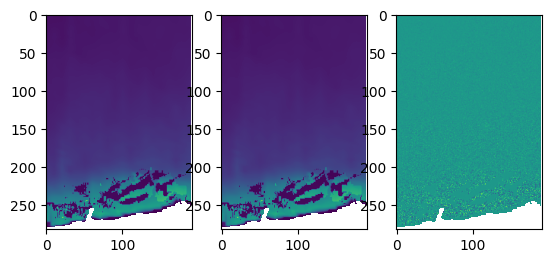

In [23]:
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(wec_diff_nodev)
ax[1].imshow(wec_diff_nodev2 / taucrit)
ax[2].imshow(wec_diff_nodev - (wec_diff_nodev2 / taucrit))
np.nanmean(wec_diff_nodev - (wec_diff_nodev2 / taucrit))

-8.257075417919146e-07

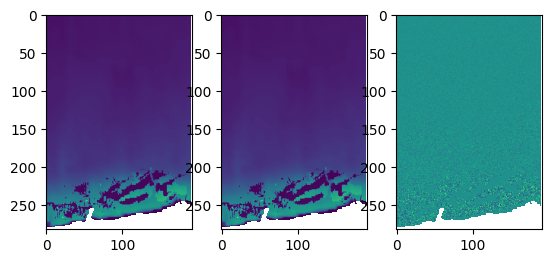

In [25]:
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(wec_diff_wecs)
ax[1].imshow(wec_diff_wecs2 / taucrit)
ax[2].imshow(wec_diff_wecs - (wec_diff_wecs2 / taucrit))
np.nanmean(wec_diff_wecs - (wec_diff_wecs2 / taucrit))

In [28]:
np.nanmin(wec_diff_nodev - wec_diff_wecs), np.nanmax(wec_diff_nodev - wec_diff_wecs)

(-8943.33507156372, 5901.642032623291)

In [29]:
np.nanmin(wec_diff_nodev2/ taucrit - wec_diff_wecs2/ taucrit), np.nanmax(wec_diff_nodev2/ taucrit - wec_diff_wecs2/ taucrit)

(-8943.334711884225, 5901.642230575089)

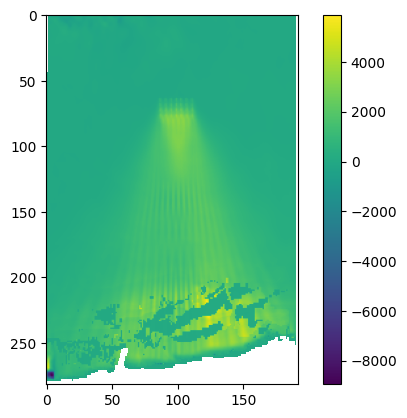

In [44]:
fig,ax = plt.subplots()
h = ax.imshow(wec_diff_nodev - wec_diff_wecs)
plt.colorbar(h, ax=ax)

In [35]:
Metric = (wec_diff_nodev - wec_diff_wecs)

In [38]:
pd.DataFrame(data=Metric.flatten()).describe()

,0
count,50825.000000
mean,689.793326
std,923.642583
min,-8943.335072
25%,20.864424
50%,214.439404
75%,1243.048493
max,5901.642033


In [40]:
pd.DataFrame(data=wec_diff.flatten()).describe()

,0
count,50825.000000
mean,-16364.048299
std,20013.833374
min,-129104.910736
25%,-20103.381151
50%,-13344.758608
75%,-8048.010298
max,55947.266930


In [39]:

# Calculate risk metrics over all runs
if plotvar == "TAUMAX" or plotvar == "VEL":
    wec_diff_nodev_sgn = np.floor(wec_diff_nodev * 25) / 25
    wec_diff_wecs_sgn = np.floor(wec_diff_wecs * 25) / 25

    wec_diff = np.sign(wec_diff_wecs_sgn - wec_diff_nodev_sgn) * wec_diff_wecs_sgn
    wec_diff = wec_diff.astype(int) + wec_diff_wecs - wec_diff_nodev

    # set to zero. Might be turning this back on
    # wec_diff[np.abs(wec_diff)<0.01] = 0

elif plotvar == "DPS":
    wec_diff = wec_diff_wecs - wec_diff_nodev
    wec_diff[np.abs(wec_diff) < 0.0005] = 0

# ========================================================

# convert to a geotiff, using wec_diff

# listOfFiles = [wec_diff_nodev, wec_diff_wecs, wec_diff, wec_diff_nodev_sgn, wec_diff_wecs_sgn]

# transpose and pull
newarray = np.transpose(wec_diff)
# we should not flip here
# array2 = np.flip(newarray, axis=0)
array2 = newarray
rows, cols = array2.shape

# return the number of rows and cols and array2
# return (rows, cols, array2)


(282, 192)

In [16]:
wec_diff_nodev_sgn = np.floor(wec_diff_nodev * 25) / 25

In [17]:
wec_diff_nodev_sgn

masked_array(
  data=[[--, 4892.52, 5181.16, ..., 8589.24, 8434.48, --],
        [--, 6147.44, 6355.6, ..., 9840.96, 10087.32, --],
        [--, 6148.56, 6346.32, ..., 9940.44, 10104.36, --],
        ...,
        [0.0, 0.0, 0.0, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True, False, False, ..., False, False,  True],
        [ True, False, False, ..., False, False,  True],
        [ True, False, False, ..., False, False,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [77]:
def calculate_receptor_change_percentage(receptor_filename, data_diff, ofpath):
    import os
    data = rio.open(receptor_filename)
    receptor_array = data.read(1)
    # transpose to be in same orientation as NetCDF
    receptor_array = np.transpose(receptor_array)
    receptor_array[receptor_array < 0] = 0
    # unique_val = np.unique(receptor_array)[2]
    pct_mobility = {'Receptor_Value': [],
                        'pct_decrease': [],
                        'pct_increase': [],
                        'pct_nochange': []}
    for unique_val in np.unique(receptor_array):
        mask = receptor_array==unique_val
        data_at_val = np.where(mask, data_diff, np.nan)
        data_at_val = data_at_val.flatten()
        data_at_val = data_at_val[~np.isnan(data_at_val)]
        ncells = data_at_val.size
        pct_mobility['Receptor_Value'].append(unique_val)
        pct_mobility['pct_decrease'].append(100 * np.size(np.flatnonzero(data_at_val<0))/ncells)
        pct_mobility['pct_increase'].append(100 * np.size(np.flatnonzero(data_at_val>0))/ncells)
        pct_mobility['pct_nochange'].append(100 * np.size(np.flatnonzero(data_at_val==0))/ncells)

        # print(f" Receptor Value = {unique_val}um | decrease = {pct_decrease}% | increase = {pct_increase}% | no change = {pct_nochange}%")
    DF = pd.DataFrame(pct_mobility)
    DF = DF.set_index('Receptor_Value')
    DF.to_csv(os.path.join(ofpath, 'receptor_percent_change.csv'))

In [78]:
def calculate_receptor_change_percentage(receptor_filename, data_diff, ofpath):
    #gdal version
    import os
    data = rio.open(receptor_filename)
    img = data.read(1)
    receptor_array = img.ReadAsArray()
    receptor_array = np.transpose(receptor_array)
    receptor_array[receptor_array < 0] = 0

    pct_mobility = {'Receptor_Value': [],
                        'pct_decrease': [],
                        'pct_increase': [],
                        'pct_nochange': []}
    for unique_val in np.unique(receptor_array):
        mask = receptor_array==unique_val
        data_at_val = np.where(mask, data_diff, np.nan)
        data_at_val = data_at_val.flatten()
        data_at_val = data_at_val[~np.isnan(data_at_val)]
        ncells = data_at_val.size
        pct_mobility['Receptor_Value'].append(unique_val)
        pct_mobility['pct_decrease'].append(100 * np.size(np.flatnonzero(data_at_val<0))/ncells)
        pct_mobility['pct_increase'].append(100 * np.size(np.flatnonzero(data_at_val>0))/ncells)
        pct_mobility['pct_nochange'].append(100 * np.size(np.flatnonzero(data_at_val==0))/ncells)

        # print(f" Receptor Value = {unique_val}um | decrease = {pct_decrease}% | increase = {pct_increase}% | no change = {pct_nochange}%")
    DF = pd.DataFrame(pct_mobility)
    DF = DF.set_index('Receptor_Value')
    DF.to_csv(os.path.join(ofpath, 'receptor_percent_change.csv'))

,pct_decrease,pct_increase,pct_nochange
Receptor_Value,,,
0.0,0.000000,0.000000,100.000000
50.0,100.000000,0.000000,0.000000
150.0,100.000000,0.000000,0.000000
300.0,82.421502,16.737787,0.840711
5000.0,99.035866,0.462784,0.501350
